 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/EMOS_network.ipynb#Theano-Implementation" data-toc-modified-id="Theano-Implementation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Theano Implementation</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/EMOS_network.ipynb#Train-for-a-single-day" data-toc-modified-id="Train-for-a-single-day-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Train for a single day</a></span></li><li><span><a href="http://localhost:8888/notebooks/EMOS_network.ipynb#Train-for-one-year" data-toc-modified-id="Train-for-one-year-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Train for one year</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/EMOS_network.ipynb#Keras-implementation" data-toc-modified-id="Keras-implementation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Keras implementation</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/EMOS_network.ipynb#Predict-for-one-day" data-toc-modified-id="Predict-for-one-day-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Predict for one day</a></span></li><li><span><a href="http://localhost:8888/notebooks/EMOS_network.ipynb#Predict-for-one-year" data-toc-modified-id="Predict-for-one-year-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Predict for one year</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/EMOS_network.ipynb#Fully-connected-model" data-toc-modified-id="Fully-connected-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fully connected model</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/EMOS_network.ipynb#For-one-day" data-toc-modified-id="For-one-day-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>For one day</a></span></li><li><span><a href="http://localhost:8888/notebooks/EMOS_network.ipynb#Train-for-the-entire-period" data-toc-modified-id="Train-for-the-entire-period-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Train for the entire period</a></span></li></ul></li></ul></div>

# EMOS Network

In [286]:
# Imports
from importlib import reload
import emos_network_theano; reload(emos_network_theano)
from  emos_network_theano import EMOS_Network, crps_cost_function
import utils; reload(utils)
from utils import *
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt

In [152]:
# Basic setup
DATA_DIR = '/Users/stephanrasp/repositories/ppnn/data/'  # Mac
fn = 'data_interpolated.nc'
window_size = 25
fclt = 48
utc = 0

## Theano Implementation

### Train for a single day

In [149]:
# Get the full dataset for 00UTC
tobs_full, tfc_full, dates = load_nc_data(DATA_DIR + fn, utc=utc)

In [224]:
# Just pick a day
date_idx = np.where(dates == datetime(2015, 6, 1, 0, 0))[0][0]
date_idx

3071

In [225]:
# Get the data slice for this particular date
tfc_mean_train, tfc_std_train, tobs_train, \
    tfc_mean_test, tfc_std_test, tobs_test = \
        get_train_test_data(tobs_full, tfc_full, date_idx, 
                            window_size, fclt)

In [226]:
# Define some model parameters
lr = np.asarray(0.1, dtype='float32')   # The learning rate
early_stopping_delta = 1e-4   # How much the CRPS must improve before stopping
steps_max = 1000   # How many steps to fit at max

In [243]:
# Set up the theano model
model_theano = EMOS_Network()

In [244]:
# Train the model for some steps
model_theano.fit(tfc_mean_train, tfc_std_train, tobs_train, steps_max, 
          (tfc_mean_test, tfc_std_test, tobs_test), lr=lr, 
          early_stopping_delta=early_stopping_delta)
# Output is the training CRPS and the test CRPS

(array(1.1621002564583596), array(0.9137559142044587))

### Train for one year

In [295]:
# Get start and stop indices
date_idx_start = np.where(dates == datetime(2008, 1, 1, 0, 0))[0][0]
date_idx_stop = np.where(dates == datetime(2008, 12, 31, 0, 0))[0][0]
date_idx_start, date_idx_stop

(363, 728)

In [296]:
model_theano = EMOS_Network()

In [297]:
train_crps_list, valid_crps_list = loop_over_days(
    model_theano,
    tobs_full, 
    tfc_full, 
    date_idx_start, date_idx_stop, 
    window_size=window_size,
    fclt=fclt,     
    epochs_max=steps_max, 
    early_stopping_delta=early_stopping_delta, 
    lr=lr,
    model_type='EMOS_Network_theano')

400
500
600
700
Time: 23.44 s


In [298]:
# Let's see what the mean prediction CRPS is
np.mean(valid_crps_list)

1.0636229038525002

The standard EMOS global score (in `standard_postprocessing/emos_global.R`) is 1.0654. So we are doing a little better even, but this might just be chance.

## Keras implementation

First, let's build the same model in Keras.

In [200]:
# import the keras modules
# Note that the cost function only works with the theano backend
import keras
from keras.layers import Input, Dense
from keras.models import Model
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD

In [187]:
# Let's build the model with Keras' functional API
# This is quite a bit easier and shorter than in theano 
# But it did take me some time to figure out the cost function, etc.
def build_EMOS_Network_keras():
    mean_in = Input(shape=(1,))
    std_in = Input(shape=(1,))
    mean_out = Dense(1, activation='linear')(mean_in)
    std_out = Dense(1, activation='linear')(std_in)
    x = keras.layers.concatenate([mean_out, std_out], axis=1)
    return Model(inputs=[mean_in, std_in], outputs=x)

In [245]:
model_keras = build_EMOS_Network_keras()

In [246]:
model_keras.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_41 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
input_42 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
dense_41 (Dense)                 (None, 1)             2           input_41[0][0]                   
____________________________________________________________________________________________________
dense_42 (Dense)                 (None, 1)             2           input_42[0][0]                   
___________________________________________________________________________________________

In [247]:
# Compile the model with SGD initilalizer
opt = SGD(lr=0.1)  
model_keras.compile(optimizer=opt, loss=crps_cost_function, 
              metrics=[crps_cost_function])

### Predict for one day

In [248]:
# This way we have the gradient descent on the whole training set just as in theano
batch_size = tfc_mean_train.shape[0]   

In [249]:
h = model_keras.fit([tfc_mean_train, tfc_std_train], tobs_train, epochs=steps_max, batch_size=batch_size,
          validation_data=[[tfc_mean_test, tfc_std_test], tobs_test], verbose=0,
          callbacks=[EarlyStopping(monitor='loss', min_delta=early_stopping_delta,
                                  patience=2)])

In [250]:
model_keras.evaluate([tfc_mean_train, tfc_std_train], tobs_train, batch_size=64)

   64/12343 [..............................] - ETA: 0s

[1.2517586752240233, 1.2517586752240233]

In [251]:
model_keras.evaluate([tfc_mean_test, tfc_std_test], tobs_test, batch_size=64)

 64/495 [==>...........................] - ETA: 0s

[1.0580770378143314, 1.0580770378143314]

Se we get slightly better results than with the theano model above. This might be due to the differences in the early stopping algorithm.

In [252]:
len(h.history['loss'])

1000

In [253]:
# But I did notice something interesting looking at the history
valid_loss = h.history['val_loss']
train_loss = h.history['loss']

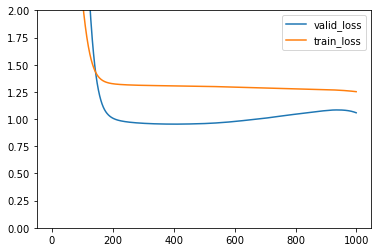

In [261]:
plt.plot(valid_loss, label='valid_loss')
plt.plot(train_loss, label='train_loss')
plt.legend()
plt.ylim(0, 2)
plt.show()

So this means we are overfitting a little. How could we avoid this. Let's pick a much longer training window.

In [255]:
# One year
tfc_mean_train, tfc_std_train, tobs_train, \
    tfc_mean_test, tfc_std_test, tobs_test = \
        get_train_test_data(tobs_full, tfc_full, date_idx, 
                            356, fclt)

In [256]:
batch_size = tfc_mean_train.shape[0]  

In [257]:
model = build_EMOS_Network_keras()
opt = SGD(lr=0.1)  
model.compile(optimizer=opt, loss=crps_cost_function, 
              metrics=[crps_cost_function])

In [258]:
h = model.fit([tfc_mean_train, tfc_std_train], tobs_train, epochs=steps_max, batch_size=batch_size,
          validation_data=[[tfc_mean_test, tfc_std_test], tobs_test], verbose=0,
          callbacks=[EarlyStopping(monitor='loss', min_delta=early_stopping_delta,
                                  patience=2)])

In [259]:
model.evaluate([tfc_mean_test, tfc_std_test], tobs_test, batch_size=64)

 64/495 [==>...........................] - ETA: 0s

[1.0561385891911841, 1.0561385891911841]

Doesn't seem to change much. Which means that either we have compensating errors or the seasonal information doesn't mean much. Here are some ideas:
- Create an actual validation data set from the training data and use it for early stopping

### Predict for one year

In [299]:
model_keras = build_EMOS_Network_keras()
opt = SGD(lr=0.1)  
model_keras.compile(optimizer=opt, loss=crps_cost_function, 
              metrics=[crps_cost_function])

In [300]:
train_crps_list, valid_crps_list = loop_over_days(
    model_keras,
    tobs_full, 
    tfc_full, 
    date_idx_start, date_idx_stop, 
    window_size=window_size,
    fclt=fclt,     
    epochs_max=steps_max, 
    early_stopping_delta=early_stopping_delta, 
    lr=lr,
    model_type='EMOS_Network_keras',
    verbose=0)

400
500
600
700
Time: 174.61 s


So the keras implementation is quite a bit slower than the pure theano version. Maybe this is due to the overhead with calling fit many many times. Which one to keep??

In [301]:
np.mean(valid_crps_list)

1.0640120236008785

In [292]:
train_crps_list

[1.0597541030445485,
 1.0666123334458606,
 1.061671031131364,
 1.0744410428044657,
 1.0880578167143964,
 1.0970980964955366]

## Fully connected model

### For one day

In [302]:
def build_fc_model():
    inp = Input(shape=(2,))
    x = Dense(2, activation='linear')(inp)
    return Model(inputs=inp, outputs=x)

In [327]:
fc_model = build_fc_model()

In [328]:
fc_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_66 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_66 (Dense)             (None, 2)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [329]:
from keras.optimizers import Adam
opt = Adam(lr=0.01)
fc_model.compile(optimizer=opt, loss=crps_cost_function, metrics=[crps_cost_function])

In [330]:
# Now we need to merge the input to a 2D vector
in_train = np.column_stack([tfc_mean_train, tfc_std_train])
in_test = np.column_stack([tfc_mean_test, tfc_std_test])
in_train.shape

(176948, 2)

In [331]:
batch_size = in_train.shape[0]  

In [332]:
h = fc_model.fit(in_train, tobs_train, epochs=400, batch_size=batch_size,
          validation_data=[in_test, tobs_test], verbose=1,
          callbacks=[EarlyStopping(monitor='loss', min_delta=early_stopping_delta,
                                  patience=2)])

Train on 176948 samples, validate on 495 samples
Epoch 1/400
176948/176948 [==============================] - 0s - loss: 7.9917 - crps_cost_function: 7.9917 - val_loss: 13.9206 - val_crps_cost_function: 13.9206
Epoch 2/400
176948/176948 [==============================] - 0s - loss: 7.9740 - crps_cost_function: 7.9740 - val_loss: 13.8900 - val_crps_cost_function: 13.8900
Epoch 3/400
176948/176948 [==============================] - 0s - loss: 7.9563 - crps_cost_function: 7.9563 - val_loss: 13.8593 - val_crps_cost_function: 13.8593
Epoch 4/400
176948/176948 [==============================] - 0s - loss: 7.9386 - crps_cost_function: 7.9386 - val_loss: 13.8287 - val_crps_cost_function: 13.8287
Epoch 5/400
176948/176948 [==============================] - 0s - loss: 7.9208 - crps_cost_function: 7.9208 - val_loss: 13.7981 - val_crps_cost_function: 13.7981
Epoch 6/400
176948/176948 [==============================] - 0s - loss: 7.9031 - crps_cost_function: 7.9031 - val_loss: 13.7674 - val_crps_co

176948/176948 [==============================] - 0s - loss: 7.1025 - crps_cost_function: 7.1025 - val_loss: 12.3762 - val_crps_cost_function: 12.3762
Epoch 52/400
176948/176948 [==============================] - 0s - loss: 7.0849 - crps_cost_function: 7.0849 - val_loss: 12.3452 - val_crps_cost_function: 12.3452
Epoch 53/400
176948/176948 [==============================] - 0s - loss: 7.0672 - crps_cost_function: 7.0672 - val_loss: 12.3141 - val_crps_cost_function: 12.3141
Epoch 54/400
176948/176948 [==============================] - 0s - loss: 7.0496 - crps_cost_function: 7.0496 - val_loss: 12.2831 - val_crps_cost_function: 12.2831
Epoch 55/400
176948/176948 [==============================] - 0s - loss: 7.0320 - crps_cost_function: 7.0320 - val_loss: 12.2521 - val_crps_cost_function: 12.2521
Epoch 56/400
176948/176948 [==============================] - 0s - loss: 7.0144 - crps_cost_function: 7.0144 - val_loss: 12.2210 - val_crps_cost_function: 12.2210
Epoch 57/400
176948/176948 [=======

176948/176948 [==============================] - 0s - loss: 6.2391 - crps_cost_function: 6.2391 - val_loss: 10.8383 - val_crps_cost_function: 10.8383
Epoch 102/400
176948/176948 [==============================] - 0s - loss: 6.2222 - crps_cost_function: 6.2222 - val_loss: 10.8080 - val_crps_cost_function: 10.8080
Epoch 103/400
176948/176948 [==============================] - 0s - loss: 6.2054 - crps_cost_function: 6.2054 - val_loss: 10.7777 - val_crps_cost_function: 10.7777
Epoch 104/400
176948/176948 [==============================] - 0s - loss: 6.1886 - crps_cost_function: 6.1886 - val_loss: 10.7474 - val_crps_cost_function: 10.7474
Epoch 105/400
176948/176948 [==============================] - 0s - loss: 6.1719 - crps_cost_function: 6.1719 - val_loss: 10.7172 - val_crps_cost_function: 10.7172
Epoch 106/400
176948/176948 [==============================] - 0s - loss: 6.1551 - crps_cost_function: 6.1551 - val_loss: 10.6870 - val_crps_cost_function: 10.6870
Epoch 107/400
176948/176948 [=

176948/176948 [==============================] - 0s - loss: 5.4210 - crps_cost_function: 5.4210 - val_loss: 9.3554 - val_crps_cost_function: 9.3554
Epoch 152/400
176948/176948 [==============================] - 0s - loss: 5.4052 - crps_cost_function: 5.4052 - val_loss: 9.3266 - val_crps_cost_function: 9.3266
Epoch 153/400
176948/176948 [==============================] - 0s - loss: 5.3894 - crps_cost_function: 5.3894 - val_loss: 9.2978 - val_crps_cost_function: 9.2978
Epoch 154/400
176948/176948 [==============================] - 0s - loss: 5.3736 - crps_cost_function: 5.3736 - val_loss: 9.2690 - val_crps_cost_function: 9.2690
Epoch 155/400
176948/176948 [==============================] - 0s - loss: 5.3578 - crps_cost_function: 5.3578 - val_loss: 9.2404 - val_crps_cost_function: 9.2404
Epoch 156/400
176948/176948 [==============================] - 0s - loss: 5.3421 - crps_cost_function: 5.3421 - val_loss: 9.2117 - val_crps_cost_function: 9.2117
Epoch 157/400
176948/176948 [=============

176948/176948 [==============================] - 0s - loss: 4.6634 - crps_cost_function: 4.6634 - val_loss: 7.9789 - val_crps_cost_function: 7.9789
Epoch 202/400
176948/176948 [==============================] - 0s - loss: 4.6491 - crps_cost_function: 4.6491 - val_loss: 7.9531 - val_crps_cost_function: 7.9531
Epoch 203/400
176948/176948 [==============================] - 0s - loss: 4.6349 - crps_cost_function: 4.6349 - val_loss: 7.9274 - val_crps_cost_function: 7.9274
Epoch 204/400
176948/176948 [==============================] - 0s - loss: 4.6207 - crps_cost_function: 4.6207 - val_loss: 7.9017 - val_crps_cost_function: 7.9017
Epoch 205/400
176948/176948 [==============================] - 0s - loss: 4.6066 - crps_cost_function: 4.6066 - val_loss: 7.8761 - val_crps_cost_function: 7.8761
Epoch 206/400
176948/176948 [==============================] - 0s - loss: 4.5925 - crps_cost_function: 4.5925 - val_loss: 7.8507 - val_crps_cost_function: 7.8507
Epoch 207/400
176948/176948 [=============

176948/176948 [==============================] - 0s - loss: 4.0115 - crps_cost_function: 4.0115 - val_loss: 6.8044 - val_crps_cost_function: 6.8044
Epoch 252/400
176948/176948 [==============================] - 0s - loss: 3.9998 - crps_cost_function: 3.9998 - val_loss: 6.7836 - val_crps_cost_function: 6.7836
Epoch 253/400
176948/176948 [==============================] - 0s - loss: 3.9883 - crps_cost_function: 3.9883 - val_loss: 6.7628 - val_crps_cost_function: 6.7628
Epoch 254/400
176948/176948 [==============================] - 0s - loss: 3.9768 - crps_cost_function: 3.9768 - val_loss: 6.7422 - val_crps_cost_function: 6.7422
Epoch 255/400
176948/176948 [==============================] - 0s - loss: 3.9653 - crps_cost_function: 3.9653 - val_loss: 6.7216 - val_crps_cost_function: 6.7216
Epoch 256/400
176948/176948 [==============================] - 0s - loss: 3.9539 - crps_cost_function: 3.9539 - val_loss: 6.7012 - val_crps_cost_function: 6.7012
Epoch 257/400
176948/176948 [=============

176948/176948 [==============================] - 0s - loss: 3.4988 - crps_cost_function: 3.4988 - val_loss: 5.8857 - val_crps_cost_function: 5.8857
Epoch 302/400
176948/176948 [==============================] - 0s - loss: 3.4899 - crps_cost_function: 3.4899 - val_loss: 5.8697 - val_crps_cost_function: 5.8697
Epoch 303/400
176948/176948 [==============================] - 0s - loss: 3.4810 - crps_cost_function: 3.4810 - val_loss: 5.8538 - val_crps_cost_function: 5.8538
Epoch 304/400
176948/176948 [==============================] - 0s - loss: 3.4722 - crps_cost_function: 3.4722 - val_loss: 5.8380 - val_crps_cost_function: 5.8380
Epoch 305/400
176948/176948 [==============================] - 0s - loss: 3.4635 - crps_cost_function: 3.4635 - val_loss: 5.8222 - val_crps_cost_function: 5.8222
Epoch 306/400
176948/176948 [==============================] - 0s - loss: 3.4547 - crps_cost_function: 3.4547 - val_loss: 5.8066 - val_crps_cost_function: 5.8066
Epoch 307/400
176948/176948 [=============

176948/176948 [==============================] - 0s - loss: 3.1067 - crps_cost_function: 3.1067 - val_loss: 5.1789 - val_crps_cost_function: 5.1789
Epoch 352/400
176948/176948 [==============================] - 0s - loss: 3.0998 - crps_cost_function: 3.0998 - val_loss: 5.1665 - val_crps_cost_function: 5.1665
Epoch 353/400
176948/176948 [==============================] - 0s - loss: 3.0930 - crps_cost_function: 3.0930 - val_loss: 5.1541 - val_crps_cost_function: 5.1541
Epoch 354/400
176948/176948 [==============================] - 0s - loss: 3.0862 - crps_cost_function: 3.0862 - val_loss: 5.1418 - val_crps_cost_function: 5.1418
Epoch 355/400
176948/176948 [==============================] - 0s - loss: 3.0795 - crps_cost_function: 3.0795 - val_loss: 5.1296 - val_crps_cost_function: 5.1296
Epoch 356/400
176948/176948 [==============================] - 0s - loss: 3.0728 - crps_cost_function: 3.0728 - val_loss: 5.1174 - val_crps_cost_function: 5.1174
Epoch 357/400
176948/176948 [=============

In [309]:
fc_model.evaluate(in_train, tobs_train, batch_size=64)

159680/176948 [==========================>...] - ETA: 0s

[nan, nan]

In [310]:
fc_model.evaluate(in_test, tobs_test, batch_size=64)

 64/495 [==>...........................] - ETA: 0s

[nan, nan]

In [333]:
fc_model.layers[-1].get_weights()

[array([[ 2.85753322, -3.69811082],
        [-0.41836253, -0.72421235]], dtype=float32),
 array([ 3.77459455, -3.75732446], dtype=float32)]

### Train for the entire period

In [ ]:
fc_model = build_fc_model()
opt = SGD(lr=0.1)  
fc_model.compile(optimizer=opt, loss=crps_cost_function, 
                 metrics=[crps_cost_function])

In [ ]:
train_crps_list, valid_crps_list = loop_over_days(
    fc_model,
    tobs_full, 
    tfc_full, 
    date_idx_start, date_idx_stop, 
    window_size=window_size,
    fclt=fclt,     
    epochs_max=steps_max, 
    early_stopping_delta=early_stopping_delta, 
    lr=lr,
    model_type='fc_model',
    verbose=0)

In [ ]:
np.mean(valid_crps_list)